## importing required libraries

In [32]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import struct
import numpy
import random
import tensorflow as tf
import os
import pickle as pickle
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [4]:
#this function helps to visualize the dict
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
# take(1, prod_desc.values())


## procedure to load the data from the json format to rating matrix

In [11]:
# load data after creating features
def load_data_hybrid(data_path, min_items=2, min_users=2, sampling= True, sample_size = 0.5):
    user_ratings = defaultdict(set)
    item_ratings = defaultdict(set)
    max_u_id = -1
    max_i_id = -1
    user_count = 0
    item_count = 0
    reviews = 0
    users = {}  # aid to id LUT
    items = {}  # asid to id LUT
    brands = {}
    prices = {}
    prod_desc = {}
    prod_cat= {}
    price_feature={}
    random.seed(0)
    with open(data_path, 'r') as f:
        bad_actor = 0
        for line in f.readlines()[1:]:
            if (sampling and random.random()>sample_size):
                continue
            reviews += 1
            num_fields = len(line.split(","))
            

            if (num_fields> 8):
                bad_actor = bad_actor + 1
                continue
            
            else:
                auid, asid, _, brand, price, product_desc, product_cat, price_feat = line.split(",")

            u, i = None, None

            if auid in users:
                u = users[auid]
            else:
                user_count += 1  # new user so increment
                users[auid] = user_count
                u = user_count
            
            if asid in items:
                i = items[asid]
            else:
                item_count += 1  # new i so increment
                items[asid] = item_count
                i = item_count
                brands[i] = brand
                if (price=='' or price=='\r\n' or price=='\n'):
                    prices[i] = 0
                else:
                    prices[i] = float(price.rstrip())
                    
                prod_desc[i] = [int(el) for el in list(product_desc)[:-1][1:]]
                if (len(prod_desc[i])==0):
                    prod_desc[i] = list(np.zeros(4524))
                
                prod_cat[i] = [int(el) for el in list(product_cat)[:-2][1:]]
                
                price_feature[i] = [int(el) for el in list(price_feat)[:-2][1:]]
            
            user_ratings[u].add(i)
            item_ratings[i].add(u)
            max_u_id = max(u, max_u_id)
            max_i_id = max(i, max_i_id)
            
    print ("max_u_id: ", max_u_id)
    print ("max_i_id: ", max_i_id)
    print ("reviews : ", reviews)


    # filter out users w/ less than X reviews
    num_u_id = 0
    num_i_id = 0
    num_reviews = 0
    user_ratings_filtered = defaultdict(set)
    for u, ids in user_ratings.items():
        if len(ids) > min_items:
            user_ratings_filtered[u] = ids
            num_u_id += 1
            num_reviews += len(ids)
            
    item_ratings_filtered = defaultdict(set)
    for ids, u in item_ratings.items():
        if len(u) > min_users:
            # keep
            item_ratings_filtered[ids] = u
            num_i_id += 1


    print ("u_id: ", num_u_id)
    print ("i_id: ", num_i_id)
    print ("reviews : ", num_reviews)
    return max_u_id, max_i_id, users, items, user_ratings_filtered,\
                item_ratings_filtered, brands, prices, prod_desc, prod_cat,price_feature

In [15]:
#example to see how ur items are being read
take(1, price_feature.items())

[(1, [0, 0, 0, 0, 1, 0])]

## LOAD DATA and verify it works properly before passing to session_run function later

In [12]:
data_path = os.path.join('', 'out_reviews_womens_cpp_product_cat_price.csv')
user_count, item_count, users, items, user_ratings, item_ratings, brands, prices, prod_desc, prod_cat,price_feature  = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)

max_u_id:  34491
max_i_id:  14764
reviews :  144992
u_id:  12305
i_id:  14764
reviews :  84164


## Procedure to load image features of the products

In [16]:
#load image features for the given asin collection into dictionary
def load_image_features(path, items):
    count=0
    image_features = {}
    f = open(path, 'rb')
    while True:
        asin = f.read(10)
        if asin == '': break
        features_bytes = f.read(16384) # 4 * 4096 = 16KB, fast read, don't unpack
  
        if asin in items: #only unpack 4096 bytes if w need it -- big speed up
            features = (np.fromstring(features_bytes, dtype=np.float32)/58.388599)
            iid=items[asin]
            if len(features)==0:
                image_features[iid] = np.zeros(4096)
            else:
                image_features[iid] = features
    
    return image_features

## Procedure to uniformly sample the (u,i,j) triplet from the raw data for the train set

In [17]:
def uniform_sample_batch(train_ratings, test_ratings, item_count, advanced_features):
    neg_items = 2
    for u in train_ratings.keys():
        t = []
        iv = []
        jv = []
        for i in train_ratings[u]:
            if (u in test_ratings.keys()):
                if (i != test_ratings[u]):  # make sure it's not in the test set
                    for k in range(1,neg_items):
                        j = random.randint(1, item_count)
                        while j in train_ratings[u]:
                            j = random.randint(1, item_count)
                        # sometimes there will not be an image for given product
                        try:
                            advanced_features[i]
                            advanced_features[j]
                        except KeyError:
                            continue
                        iv.append(advanced_features[i])
                        jv.append(advanced_features[j])
                        t.append([u, i, j])
            else:
                for k in range(1,neg_items):
                    j = random.randint(1, item_count)
                    while j in train_ratings[u]:
                        j = random.randint(1, item_count)
                    # sometimes there will not be an image for given product
                    try:
                        advanced_features[i]
                        advanced_features[j]
                    except KeyError:
                        continue
                    iv.append(advanced_features[i])
                    jv.append(advanced_features[j])
                    t.append([u, i, j])

        # block if queue is full
        if len(iv)>1:
            yield numpy.asarray(t), numpy.vstack(tuple(iv)), numpy.vstack(tuple(jv))
        else:
            continue

## Procedure to uniformly sample the (u,i,j) triplet from the raw data for the test set

In [28]:
def test_batch_generator_by_user(train_ratings, test_ratings, item_ratings, item_count, advanced_features, cold_start = False, cold_start_thresh = 5):
    # using leave one cv
    for u in random.sample(test_ratings.keys(), 4000):
    #for u in test_ratings.keys():
        i = test_ratings[u]
        if (cold_start and len(item_ratings[i]) > cold_start_thresh-1):
            continue
        t = []
        ilist = []
        jlist = []
        count = 0
        for j in random.sample(range(item_count), 100):
            # find item not in test[u] and train[u]
            if j != test_ratings[u] and not (j in train_ratings[u]):
                try:
                    advanced_features[i]
                    advanced_features[j]
                except KeyError:
                    continue

                count += 1
                t.append([u, i, j])
                ilist.append(advanced_features[i])
                jlist.append(advanced_features[j])

        # print numpy.asarray(t).shape
        # print numpy.vstack(tuple(ilist)).shape
        # print numpy.vstack(tuple(jlist)).shape
        if (len(ilist) == 0):
            #print "could not find neg item for user, count: ", count, u
            continue
        yield numpy.asarray(t), numpy.vstack(tuple(ilist)), numpy.vstack(tuple(jlist))

## Procedure to generate the (u,i) pair for the test data

In [19]:
def generate_test(user_ratings):
    '''
    for each user, random select one rating into test set
    '''
    user_test = dict()
    for u, i_list in user_ratings.items():
        user_test[u] = random.sample(user_ratings[u], 1)[0]
    return user_test

## Bayesian Personalized Ranking (BPR) Model and it's extensions (VBPR, NVBPR, Hybrid)

In [20]:
def abpr(user_count, item_count, advanced_features, bpr_extension, hidden_dim=10, hidden_img_dim=10,
         l2_regulization=0.1,
         bias_regulization=0.01,
         embed_regulization = 0,
         image_regulization =0.1,
         visual_bias_regulization = 0.01):
    """
    user_count: total number of users
    item_count: total number of items
    hidden_dim: hidden feature size of MF
    hidden_img_dim: hidden visual/non-visual feature size of MF
    """
  
    advanced_feat_dim = len(advanced_features[1])
    iv = tf.placeholder(tf.float32, [None, advanced_feat_dim])
    jv = tf.placeholder(tf.float32, [None, advanced_feat_dim])
    
    u = tf.placeholder(tf.int32, [None])
    i = tf.placeholder(tf.int32, [None])
    j = tf.placeholder(tf.int32, [None])


  

    
    # model parameters -- LEARN THESE
    # latent factors
    user_emb_w = tf.get_variable("user_emb_w", [user_count + 1, hidden_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
    item_emb_w = tf.get_variable("item_emb_w", [item_count + 1, hidden_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
    # biases
    item_b = tf.get_variable("item_b", [item_count + 1, 1], initializer=tf.constant_initializer(0.0))

    # pull out the respective latent factor vectors for a given user u and items i & j
    u_emb = tf.nn.embedding_lookup(user_emb_w, u)
    i_emb = tf.nn.embedding_lookup(item_emb_w, i)
    j_emb = tf.nn.embedding_lookup(item_emb_w, j)
    
    # get the respective biases for items i & j
    i_b = tf.nn.embedding_lookup(item_b, i)
    j_b = tf.nn.embedding_lookup(item_b, j)


    # MF predict: u_i > u_j
   
    
    if bpr_extension:
        # UxD visual factors for users
        user_img_w = tf.get_variable("user_img_w", [user_count + 1, hidden_img_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
        # this is E, the embedding matrix
        img_emb_w = tf.get_variable("img_emb_w", [hidden_img_dim, advanced_feat_dim],
                                initializer=tf.random_normal_initializer(0, 0.1))
        
        theta_i = tf.matmul(iv, img_emb_w, transpose_b=True)  # (f_i * E), eq. 3
        theta_j = tf.matmul(jv, img_emb_w, transpose_b=True)  # (f_j * E), eq. 3

        visual_bias = tf.get_variable("visual_bias", [1, advanced_feat_dim], initializer=tf.random_normal_initializer(0, 0.1))
        # pull out the visual factor, 1 X D for user u
        
        u_img = tf.nn.embedding_lookup(user_img_w, u)
        
        xui = i_b + tf.reduce_sum(tf.multiply(u_emb, i_emb), 1, keep_dims=True) + tf.reduce_sum(tf.multiply(u_img, theta_i), 1, keep_dims=True) \
                                                                            + tf.reduce_sum(tf.multiply(visual_bias, iv), 1, keep_dims=True) 
        xuj = j_b + tf.reduce_sum(tf.multiply(u_emb, j_emb), 1, keep_dims=True) + tf.reduce_sum(tf.multiply(u_img, theta_j), 1, keep_dims=True) \
                                                                            + tf.reduce_sum(tf.multiply(visual_bias, jv), 1, keep_dims=True) 
        l2_norm = tf.add_n([
            l2_regulization * tf.reduce_sum(tf.multiply(u_emb, u_emb)),
            image_regulization * tf.reduce_sum(tf.multiply(u_img, u_img)),
            l2_regulization * tf.reduce_sum(tf.multiply(i_emb, i_emb)),
            l2_regulization * tf.reduce_sum(tf.multiply(j_emb, j_emb)),
            embed_regulization * tf.reduce_sum(tf.multiply(img_emb_w, img_emb_w)),
            bias_regulization * tf.reduce_sum(tf.multiply(i_b, i_b)),
            bias_regulization * tf.reduce_sum(tf.multiply(j_b, j_b)),
            visual_bias_regulization * tf.reduce_sum(tf.multiply(visual_bias, visual_bias))
        ])
        
    
    
    else:
        xui = i_b + tf.reduce_sum(tf.multiply(u_emb, i_emb), 1, keep_dims=True)
        xuj = j_b + tf.reduce_sum(tf.multiply(u_emb, j_emb), 1, keep_dims=True) 
        l2_norm = tf.add_n([
            l2_regulization * tf.reduce_sum(tf.multiply(u_emb, u_emb)),
            l2_regulization * tf.reduce_sum(tf.multiply(i_emb, i_emb)),
            l2_regulization * tf.reduce_sum(tf.multiply(j_emb, j_emb)),
            bias_regulization * tf.reduce_sum(tf.multiply(i_b, i_b)),
            bias_regulization * tf.reduce_sum(tf.multiply(j_b, j_b))
        ])
    
    xuij = xui - xuj

    auc = tf.reduce_mean(tf.to_float(xuij > 0))
    
    loss = l2_norm - tf.reduce_mean(tf.log(tf.sigmoid(xuij)))
    
    train_op = tf.train.AdamOptimizer().minimize(loss)
    
    
    return u, i, j, iv, jv, loss, auc, train_op

## Procedure to run the end-to-end model (from loading data to training the model and to test the model)

In [33]:
def session_run(num_iter, bpr_extension, advanced_features):
    ### Loading and parsing the review matrix for Women 5-core dataset
    auc_train = []
    auc_test = []
    auc_test_cs = []
    data_path = os.path.join('', 'out_reviews_womens_cpp_product_cat_price.csv')
    user_count, item_count, users, items, user_ratings, item_ratings, brands, _, prod_desc, prod_cat,price_feature = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
    user_ratings_test = generate_test(user_ratings)
    with tf.Graph().as_default(), tf.Session() as session:
        with tf.variable_scope('abpr'):
            u, i, j, iv, jv, loss, auc, train_op = abpr(user_count, item_count, advanced_features, bpr_extension=bpr_extension)

        session.run(tf.global_variables_initializer())
        

        for epoch in range(1, num_iter+1):
            print ("epoch ", epoch)
            _loss_train = 0.0
            user_count = 0
            auc_train_values = []
            for d, _iv, _jv in uniform_sample_batch(user_ratings, user_ratings_test, item_count, advanced_features):
                user_count += 1
                _loss, _auc, _ = session.run([loss, auc, train_op], feed_dict={u:d[:,0], i:d[:,1], j:d[:,2], iv:_iv, jv:_jv})
                _loss_train += _loss
                auc_train_values.append(_auc)
            print ("train_loss:", _loss_train/user_count, "train auc: ", numpy.mean(auc_train_values))
            auc_train.append(numpy.mean(auc_train_values))


            auc_values = []
            _loss_test = 0.0
            user_count = 0
            for d, _iv, _jv in test_batch_generator_by_user(user_ratings, user_ratings_test, item_ratings, item_count, advanced_features, cold_start = False):
                user_count += 1
                _loss, _auc = session.run([loss, auc], feed_dict={u: d[:, 0], i: d[:, 1], j: d[:, 2], iv: _iv, jv: _jv})
                _loss_test += _loss
                auc_values.append(_auc)
            print ("test_loss: ", _loss_test / user_count, "test auc: ", numpy.mean(auc_values))
            auc_test.append(numpy.mean(auc_values))

            auc_values_cs = []
            _loss_test_cs = 0.0
            user_count = 0
            for d, _iv, _jv in test_batch_generator_by_user(user_ratings, user_ratings_test, item_ratings, item_count, advanced_features, cold_start = True, cold_start_thresh = 10):
                user_count += 1
                _loss, _auc = session.run([loss, auc], feed_dict={u: d[:, 0], i: d[:, 1], j: d[:, 2], iv: _iv, jv: _jv})
                _loss_test_cs += _loss
                auc_values_cs.append(_auc)
            print ("cold start test_loss: ", _loss_test_cs / user_count, "cold start auc: ", numpy.mean(auc_values_cs))
            auc_test_cs.append(numpy.mean(auc_values_cs))
        return auc_train, auc_test, auc_test_cs

## Loading the image related feature

In [ ]:
# Uncomment the lines below to LOAD IMAGE features. It will take some time.
# images_path = "image_features_Women.b"
# f = load_image_features(images_path, items)

## Running the base VBPR model with image features ONLY but no advanced features

In [ ]:
#Uncomment the line below once you have already loaded the image images in f
#vbpr_auc_train, vbpr_auc_test, vbpr_auc_test_cold_start = session_run(5, True, f)

## Running BASELINE BPR with no advanced features at all

In [342]:
#Note: bpr_extension is True only when you are passing image features, else always false

dummy_adv_features= {n: [0] for n in range(1,item_count+1)} # creating dummy array with zero for NO advanced features
bpr_auc_train, bpr_auc_test, bpr_auc_test_cold_start = session_run(10, True, dummy_adv_features)

max_u_id:  34491
max_i_id:  14764
reviews :  144992
u_id:  12305
i_id:  14764
reviews :  84164
epoch  1
train_loss: 0.830495092204 train auc:  0.622237
test_loss:  2.12884474048 test auc:  0.654812
cold start test_loss:  2.17079120234 cold start auc:  0.399922
epoch  2
train_loss: 0.718062192933 train auc:  0.689784
test_loss:  1.57902501328 test auc:  0.648497
cold start test_loss:  1.59874229559 cold start auc:  0.374105
epoch  3
train_loss: 0.665078992039 train auc:  0.70954
test_loss:  1.34379753539 test auc:  0.64774
cold start test_loss:  1.33150363743 cold start auc:  0.373923
epoch  4
train_loss: 0.634860334392 train auc:  0.714478
test_loss:  1.25928304617 test auc:  0.6459
cold start test_loss:  1.23651254654 cold start auc:  0.37466
epoch  5
train_loss: 0.616732381791 train auc:  0.722573
test_loss:  1.25971108092 test auc:  0.648819
cold start test_loss:  1.2289960426 cold start auc:  0.372405
epoch  6
train_loss: 0.60716787202 train auc:  0.721306
test_loss:  1.30613588554

## NEW PRICE FEATURE CREATED

In [34]:
npbpr_auc_train, npbpr_auc_test, npbpr_auc_test_cold_start = session_run(10, True, price_feature)

max_u_id:  34491
max_i_id:  14764
reviews :  144992
u_id:  12305
i_id:  14764
reviews :  84164
epoch  1
train_loss: 0.825061865669 train auc:  0.610299
test_loss:  2.14893983175 test auc:  0.573874
cold start test_loss:  2.21948544847 cold start auc:  0.460475
epoch  2
train_loss: 0.714823526301 train auc:  0.678288
test_loss:  1.66714386408 test auc:  0.608788
cold start test_loss:  1.69019085299 cold start auc:  0.425808
epoch  3
train_loss: 0.652171691438 train auc:  0.720035
test_loss:  1.55819371442 test auc:  0.643691
cold start test_loss:  1.54043298866 cold start auc:  0.446561
epoch  4
train_loss: 0.59074763787 train auc:  0.756786
test_loss:  1.61542718525 test auc:  0.656394
cold start test_loss:  1.60039201252 cold start auc:  0.477419
epoch  5
train_loss: 0.543155736588 train auc:  0.781254
test_loss:  1.72957871015 test auc:  0.657689
cold start test_loss:  1.68808029693 cold start auc:  0.504638
epoch  6
train_loss: 0.515406652894 train auc:  0.794844
test_loss:  1.83414

## Generating the price related feature and running the advanced BPR model with price features only

In [344]:
#user_count, item_count, users, items, user_ratings, item_ratings, brands, prices, prod_desc = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
prices_features= {}
prices_all = list(set(prices.values()))
price_quant_level = 10
price_max = float(max(prices.values()))
for key, value in prices.items():
    prices_vec = numpy.zeros(price_quant_level+1)
    idx = int(numpy.ceil(float(value)/(price_max/price_quant_level)))
    prices_vec[idx]=1
    prices_features[key] = prices_vec

In [345]:
pbpr_auc_train, pbpr_auc_test, pbpr_auc_test_cold_start = session_run(10, True, prices_features)

max_u_id:  34491
max_i_id:  14764
reviews :  144992
u_id:  12305
i_id:  14764
reviews :  84164
epoch  1
train_loss: 0.830046996224 train auc:  0.611581
test_loss:  2.13747107898 test auc:  0.64148
cold start test_loss:  2.19058188581 cold start auc:  0.421771
epoch  2
train_loss: 0.716808176116 train auc:  0.681906
test_loss:  1.63339434841 test auc:  0.645305
cold start test_loss:  1.63657856769 cold start auc:  0.397937
epoch  3
train_loss: 0.658279769947 train auc:  0.714073
test_loss:  1.5092749957 test auc:  0.640888
cold start test_loss:  1.50431845418 cold start auc:  0.416374
epoch  4
train_loss: 0.61734355246 train auc:  0.728764
test_loss:  1.55204826339 test auc:  0.632821
cold start test_loss:  1.52232751077 cold start auc:  0.425732
epoch  5
train_loss: 0.597164308513 train auc:  0.739059
test_loss:  1.58859637979 test auc:  0.637595
cold start test_loss:  1.58318181618 cold start auc:  0.416297
epoch  6
train_loss: 0.584418645399 train auc:  0.743965
test_loss:  1.6532217

## Generating the brand related feature and running the advanced BPR model with brand features only

In [346]:
brands_features = {}
brands_all = list(set(brands.values()))
for key, value in brands.items():
    brands_vec = numpy.zeros(len(brands_all))
    brands_vec[brands_all.index(value)] = 1
    brands_features[key] = brands_vec
bbpr_auc_train, bbpr_auc_test, bbpr_auc_test_cold_start = session_run(10, True, brands_features)

max_u_id:  34491
max_i_id:  14764
reviews :  144992
u_id:  12305
i_id:  14764
reviews :  84164
epoch  1
train_loss: 0.826916610705 train auc:  0.631551
test_loss:  2.1576431134 test auc:  0.618061
cold start test_loss:  2.21878106676 cold start auc:  0.44343
epoch  2
train_loss: 0.713241369346 train auc:  0.706354
test_loss:  1.68672971997 test auc:  0.633653
cold start test_loss:  1.70322656154 cold start auc:  0.413656
epoch  3
train_loss: 0.653979188657 train auc:  0.739304
test_loss:  1.54739060669 test auc:  0.652522
cold start test_loss:  1.55593563238 cold start auc:  0.420277
epoch  4
train_loss: 0.607445154724 train auc:  0.768876
test_loss:  1.59463945107 test auc:  0.668006
cold start test_loss:  1.57836938645 cold start auc:  0.443628
epoch  5
train_loss: 0.559750693353 train auc:  0.801141
test_loss:  1.73619137844 test auc:  0.679768
cold start test_loss:  1.73741982997 cold start auc:  0.466054
epoch  6
train_loss: 0.520973963079 train auc:  0.820673
test_loss:  1.903300

## Generating Categories of product feature and running advanced BPR model with product categories only

In [347]:
cbpr_auc_train, cbpr_auc_test, cbpr_auc_test_cold_start = session_run(10, True, prod_cat)

max_u_id:  34491
max_i_id:  14764
reviews :  144992
u_id:  12305
i_id:  14764
reviews :  84164
epoch  1
train_loss: 0.810557359268 train auc:  0.630228
test_loss:  2.29361186653 test auc:  0.551086
cold start test_loss:  2.36694689213 cold start auc:  0.496141
epoch  2
train_loss: 0.698183138581 train auc:  0.693348
test_loss:  1.89098103301 test auc:  0.582414
cold start test_loss:  1.91176690795 cold start auc:  0.491235
epoch  3
train_loss: 0.612705150053 train auc:  0.751163
test_loss:  1.79424659014 test auc:  0.649468
cold start test_loss:  1.78917357764 cold start auc:  0.551769
epoch  4
train_loss: 0.526970455 train auc:  0.799827
test_loss:  1.81883182921 test auc:  0.686855
cold start test_loss:  1.79763009689 cold start auc:  0.597483
epoch  5
train_loss: 0.464454919873 train auc:  0.832258
test_loss:  1.86277620889 test auc:  0.711504
cold start test_loss:  1.88138595585 cold start auc:  0.613939
epoch  6
train_loss: 0.424384235036 train auc:  0.851336
test_loss:  1.9195430

## Generating the product description related feature and running the advanced BPR model with product description generated features only

In [341]:
# pdbpr_auc_train, pdbpr_auc_test, pdbpr_auc_test_cold_start = session_run(5, True, prod_desc)

max_u_id:  34491
max_i_id:  14764
reviews :  144992
u_id:  12305
i_id:  14764
reviews :  84164
epoch  1


ValueError: all the input array dimensions except for the concatenation axis must match exactly

## Running the advanced BPR model with the hybrid of all non-visual features:  price+brand+product description features (NVBPR)

In [ ]:
a = prices_features
b = brands_features
c = dict([(k, numpy.append(a[k],b[k])) for k in set(b) & set(a)])
d= prod_desc
e = dict([(k, numpy.append(c[k],d[k])) for k in set(c) & set(d)])

hybrid_non_visual_features = e
nvbpr_auc_train, nvbpr_auc_test, nvbpr_auc_test_cold_start = session_run(5, False, hybrid_non_visual_features)

## Running the base advanced BPR model with the hybrid of all visual and non-visual features: image+price+brand+product description features (HBPR)

In [ ]:
# uncomment the lines below once you have image features loaded
# hybrid_all_features = dict([(k, numpy.append(e[k],f[k])) for k in set(e) & set(f)])
# hbpr_auc_train, hbpr_auc_test, hbpr_auc_test_cold_start = session_run(5, True, hybrid_all_features)

## comparing Test AUC vs. number of iterations for different models

In [372]:
print ("The average AUC of BPR: {0:0.2f} with best score of {1:0.2f}".format(sum(bpr_auc_test)/len(bpr_auc_test), max(bpr_auc_test)))
print ("The average AUC of Price-BPR: {0:0.2f} with best score of {1:0.2f}".format(sum(pbpr_auc_test)/len(pbpr_auc_test),max(pbpr_auc_test)))
print ("The average AUC of Brand-BPR: {0:0.2f} with best score of {1:0.2f}".format(sum(bbpr_auc_test)/len(bbpr_auc_test),max(bbpr_auc_test)))
print ("The average AUC of Product Categories-BPR: {0:0.2f} with best score of {1:0.2f}".format(sum(cbpr_auc_test)/len(cbpr_auc_test),max(cbpr_auc_test)))

The average AUC of BPR: 0.65 with best score of 0.66
The average AUC of Price-BPR: 0.64 with best score of 0.65
The average AUC of Brand-BPR: 0.67 with best score of 0.70
The average AUC of Product Categories-BPR: 0.68 with best score of 0.74


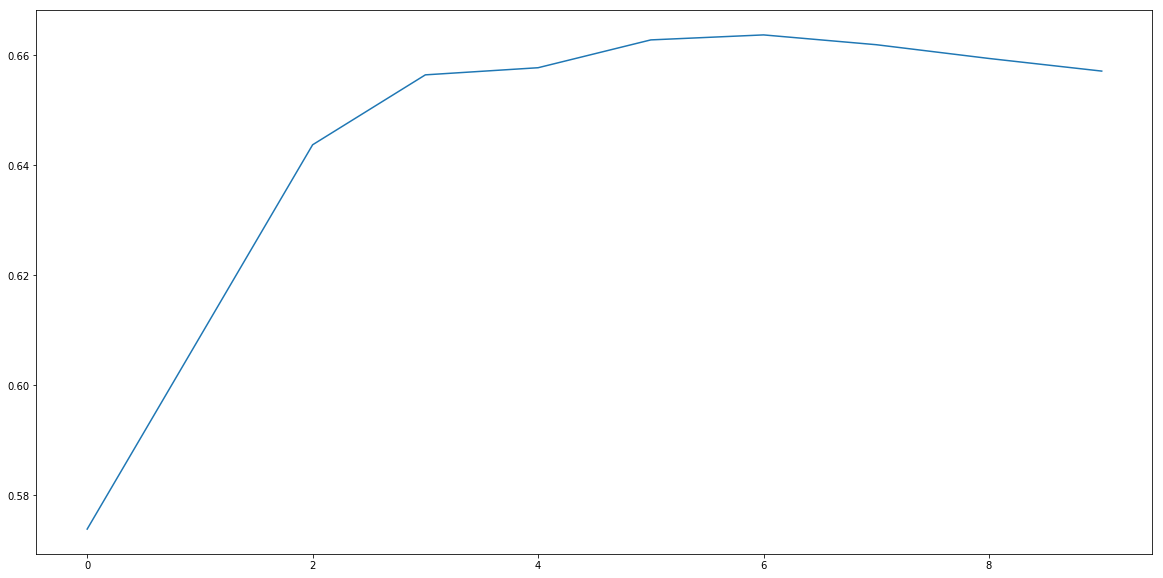

In [37]:
plt.figure(figsize=(20,10))
plt.plot(npbpr_auc_test, label = "NEW-PRICE-BPR")

In [35]:
plt.figure(figsize=(20,10))
plt.plot(bpr_auc_test, label = "BPR")
plt.plot(npbpr_auc_test, label = "BPR")
plt.plot(pbpr_auc_test, label = "Price-BPR")
plt.plot(bbpr_auc_test, label = "Brand-BPR")
# plt.plot(pdbpr_auc_test, label = "Product Description-BPR")
plt.plot(cbpr_auc_test,label="Product Categories-BPR")
# plt.plot(nvbpr_auc_test, label = "NonVisual-BPR")
# plt.plot(vbpr_auc_test, label = "Visual-BPR")
# plt.plot(hbpr_auc_test, label = "Hybrid-BPR")
plt.legend()
plt.ylabel("Test AUC")
plt.xlabel("Number of Iterations")
plt.figure.savefig('testauc.png')

NameError: name 'bpr_auc_test' is not defined

## comparing Cold Start Test AUC vs. number of iterations for different models

Text(0.5,0,'Number of Iterations')

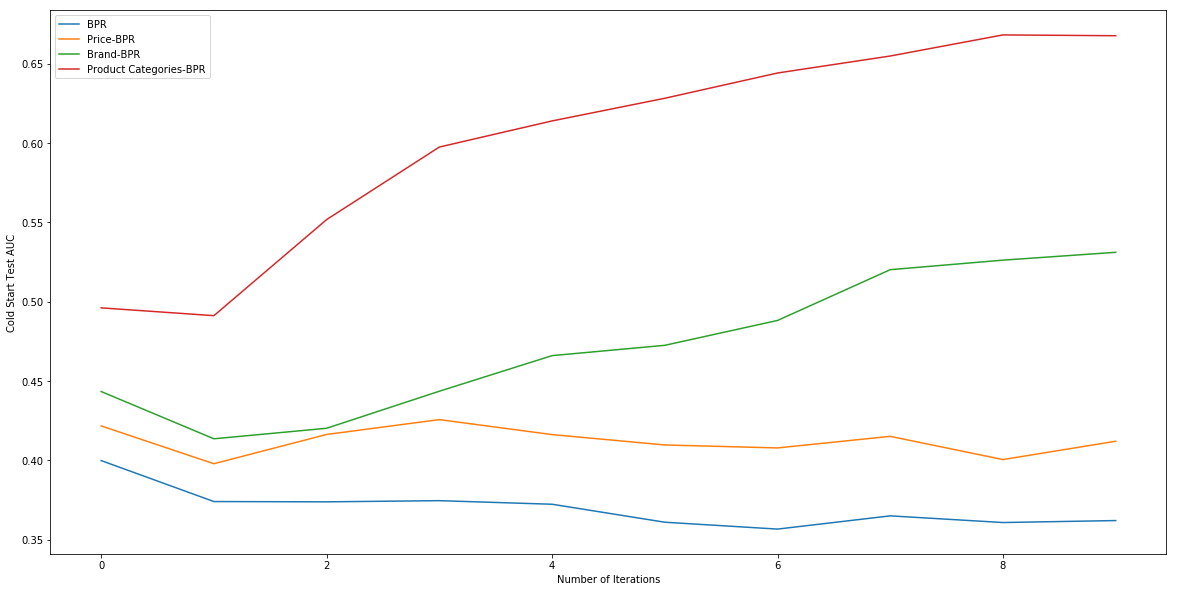

In [349]:
plt.figure(figsize=(20,10))
plt.plot(bpr_auc_test_cold_start, label = "BPR")
plt.plot(pbpr_auc_test_cold_start, label = "Price-BPR")
plt.plot(bbpr_auc_test_cold_start, label = "Brand-BPR")
# plt.plot(pdbpr_auc_test_cold_start, label = "Product Description-BPR")
plt.plot(cbpr_auc_test_cold_start, label = "Product Categories-BPR")
# plt.plot(nvbpr_auc_test_cold_start, label = "NonVisual-BPR")
# plt.plot(vbpr_auc_test_cold_start, label = "Visual-BPR")
# plt.plot(hbpr_auc_test_cold_start, label = "Hybrid-BPR")
plt.legend()
plt.ylabel("Cold Start Test AUC")
plt.xlabel("Number of Iterations")

## Writing the results to a CSV file

In [ ]:
import csv
rows = zip(bpr_auc_test, pbpr_auc_test, bbpr_auc_test, pdbpr_auc_test, nvbpr_auc_test, vbpr_auc_test, 
           hbpr_auc_test, bpr_auc_test_cold_start, pbpr_auc_test_cold_start, bbpr_auc_test_cold_start,
          pdbpr_auc_test_cold_start, nvbpr_auc_test_cold_start, vbpr_auc_test_cold_start, hbpr_auc_test_cold_start)

with open("AUC_5core_Women.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["bpr_auc_test", "pbpr_auc_test", "bbpr_auc_test", "pdbpr_auc_test", "nvbpr_auc_test", 
                     "vbpr_auc_test", "hbpr_auc_test", "bpr_auc_test_cold_start", "pbpr_auc_test_cold_start",
                    "bbpr_auc_test_cold_start", "pdbpr_auc_test_cold_start", "nvbpr_auc_test_cold_start",
                    "vbpr_auc_test_cold_start", "hbpr_auc_test_cold_start"])
    for row in rows:
        writer.writerow(row)